# Comparison


In [18]:
import pandas as pd
import numpy as np
import os
import pickle

pd.set_option("display.max_columns", None)

In [19]:
from scripts.params import get_params
from scripts.aux_functions import get_all_results_matching, subset_of_columns, clean_modelname

params = get_params()

In [20]:
from scripts.epftoolbox_dm_gw import DM, plot_multivariate_DM_test, GW, plot_multivariate_GW_test

In [21]:
dataroute = params["dataroute"]
resultsroute = params["resultsroute"]
dumproute = params["dumproute"]
graphsroute = params["graphsroute"]
dmroute=params["dmroute"]
gwroute=params["gwroute"]

In [22]:
start_test = params["start_test"]
local_suffix = params["local_suffix"]

In [23]:
name = f'finaldf_test_{params["tablename"]}.pickle'
filename = os.path.join(dataroute, name)
with open(filename, "rb") as handle:
    df_test = pickle.load(handle)
    
df_test.index=pd.to_datetime(df_test.index.copy())

In [24]:
all_residual = get_all_results_matching(params["resultsroute"], ["best_residual"])
all_residuals = get_all_results_matching(params["resultsroute"], ["best_residuals"])

{'GARCH_AR_^MERV_aic_best_forecasts.pickle': '..\\results\\AR_^MERV\\GARCH_AR_^MERV_aic_best_forecasts.pickle', 'GARCH_AR_^MERV_bic_best_forecasts.pickle': '..\\results\\AR_^MERV\\GARCH_AR_^MERV_bic_best_forecasts.pickle', 'HMM_multiv_AR_^MERV_aic_best_forecasts.pickle': '..\\results\\AR_^MERV\\HMM_multiv_AR_^MERV_aic_best_forecasts.pickle', 'HMM_multiv_AR_^MERV_bic_best_forecasts.pickle': '..\\results\\AR_^MERV\\HMM_multiv_AR_^MERV_bic_best_forecasts.pickle', 'HMM_univ_AR_^MERV_aic_best_forecasts.pickle': '..\\results\\AR_^MERV\\HMM_univ_AR_^MERV_aic_best_forecasts.pickle', 'HMM_univ_AR_^MERV_bic_best_forecasts.pickle': '..\\results\\AR_^MERV\\HMM_univ_AR_^MERV_bic_best_forecasts.pickle', 'HMM_with_vol_AR_^MERV_aic_best_forecasts.pickle': '..\\results\\AR_^MERV\\HMM_with_vol_AR_^MERV_aic_best_forecasts.pickle', 'HMM_with_vol_AR_^MERV_bic_best_forecasts.pickle': '..\\results\\AR_^MERV\\HMM_with_vol_AR_^MERV_bic_best_forecasts.pickle', 'VAR_multiv_AR_^MERV_aic_best_forecasts.pickle': '.

In [25]:
def open_pickle_route(route:str):
    with open(route, "rb") as file:
        dictionary = pickle.load(file)
    return dictionary

In [26]:
def create_prefix(picklename:str):
    picklename=picklename.replace(f"""{params["tablename"]}_""", "").replace(".pickle", "").replace("_residuals", "").replace("_forecasts", "").replace("best", "")
    return picklename

In [27]:
def concat_dictionary(dictionary:dict, prefix:str):
    colname_list=[]
    df_list=[]
    for key, value in dictionary.items():
        value.index = pd.to_datetime(value.index)
        value = subset_of_columns(value, "log_rets", "USD")
        
        df_list.append(value)
        
        colname = prefix + key
        colname_list.append(colname)
    
    pickledf = pd.concat(df_list, axis=1, join="outer")
    pickledf.columns = colname_list
    
    return pickledf

In [28]:
def aggregate_single_pickle(picklename:str, pickleroute:str):
    prefix = create_prefix(picklename)
    dictionary = open_pickle_route(pickleroute)
    pickledf = concat_dictionary(dictionary, prefix)
    return pickledf

In [29]:
def aggregate_dict(dictionary:dict):
    pickledf_list=[]
    for picklename, pickleroute in dictionary.items():
        pickledf = aggregate_single_pickle(picklename, pickleroute)
        pickledf_list.append(pickledf)
    aggdf = pd.concat(pickledf_list, axis=1, join="outer")
    
    return aggdf

In [32]:
forecasts = aggregate_dict(all_forecasts)
residuals = aggregate_dict(all_residuals)

In [36]:
lower_date=pd.to_datetime(params["start_test"])+pd.Timedelta(days=1)
higher_date=pd.to_datetime(params["end_test"])-pd.Timedelta(days=1)

forecasts_df=forecasts[lower_date:higher_date].copy()
residual_df=residuals[lower_date:higher_date].copy()
df_test = df_test[lower_date:higher_date].copy()

In [37]:
# estadisticos de nans
nans_forecasts=((forecasts_df.isna().sum(axis=0) / len(forecasts_df.index)) * 100).nlargest(10)
assert nans_forecasts.iloc[0]<5, "Forecast NANs above 5%"
nans_forecasts

GARCH_aic_MERV_FX    0.0
GARCH_aic_^MERV      0.0
GARCH_aic_GGAL.BA    0.0
GARCH_aic_GGAL       0.0
GARCH_aic_YPFD.BA    0.0
GARCH_aic_YPF        0.0
GARCH_aic_EDN.BA     0.0
GARCH_aic_EDN        0.0
GARCH_aic_BMA.BA     0.0
GARCH_aic_BMA        0.0
dtype: float64

In [38]:
# estadisticos de nans
nans_residual=((residual_df.isna().sum(axis=0) / len(residual_df.index)) * 100).nlargest(10)
assert nans_residual.iloc[0]<5, "Forecast NANs above 5%"
nans_residual

GARCH_aic_MERV_FX    0.0
GARCH_aic_^MERV      0.0
GARCH_aic_GGAL.BA    0.0
GARCH_aic_GGAL       0.0
GARCH_aic_YPFD.BA    0.0
GARCH_aic_YPF        0.0
GARCH_aic_EDN.BA     0.0
GARCH_aic_EDN        0.0
GARCH_aic_BMA.BA     0.0
GARCH_aic_BMA        0.0
dtype: float64

## Separating in different stocks

In [52]:
params["assetlist"]

['MERV_FX',
 '^MERV',
 'GGAL.BA',
 'GGAL',
 'YPFD.BA',
 'YPF',
 'EDN.BA',
 'EDN',
 'BMA.BA',
 'BMA',
 'BBAR.BA',
 'BBAR']

In [53]:
def separate_by_stock(df:pd.DataFrame):
     stock_dict={}

     for stock in params["assetlist"]:
          if params["local_suffix"] in stock:
               stock_dict[stock]= subset_of_columns(residual_df, stock)
          else:
               stock_dict[stock]= subset_of_columns(residual_df, stock, params["local_suffix"])    
     
     return stock_dict      

In [54]:
forecasts_by_stock=separate_by_stock(forecasts_df)
residuals_by_stock=separate_by_stock(residual_df)

In [55]:
for df_clean, name in zip([forecasts_by_stock, residuals_by_stock], ["forecasts", "residuals"]):
    bystockname = name + "_by_stock_" + params["tablename"] + ".pickle"
    with open(os.path.join(resultsroute, bystockname), "wb") as handle:
        pickle.dump(df_clean, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [56]:
def delete_in_column_names(df:pd.DataFrame, string:str):
    new_cols=[]
    for col in df.columns:
        col=col.replace(string, "")
        new_cols.append(col)
    df=df.set_axis(labels=new_cols, axis=1)
    return df

MERV_FX


c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: invalid value encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)
c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: divide by zero encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)


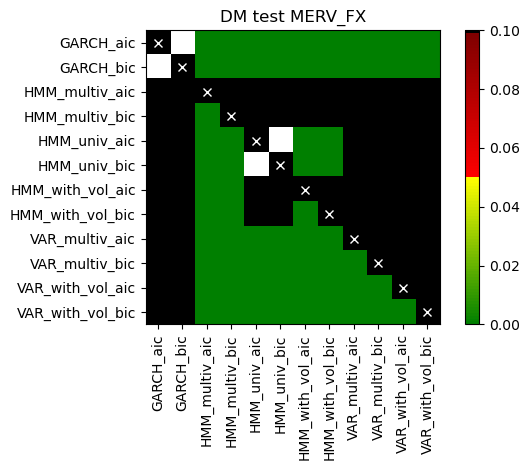

^MERV


c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: divide by zero encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)
c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: invalid value encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)


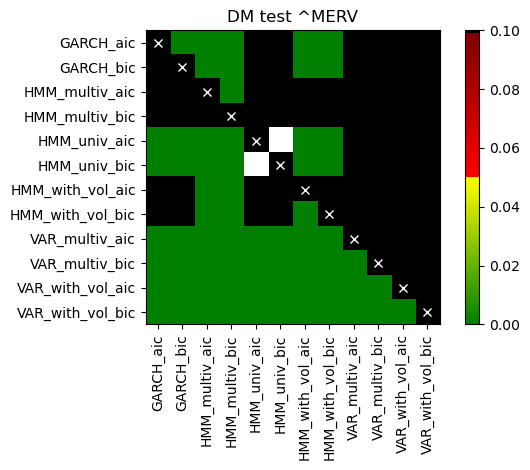

GGAL.BA


c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: divide by zero encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)


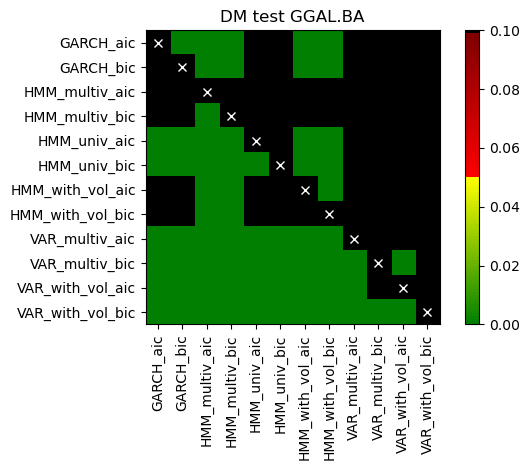

GGAL


c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: divide by zero encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)
c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: invalid value encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)


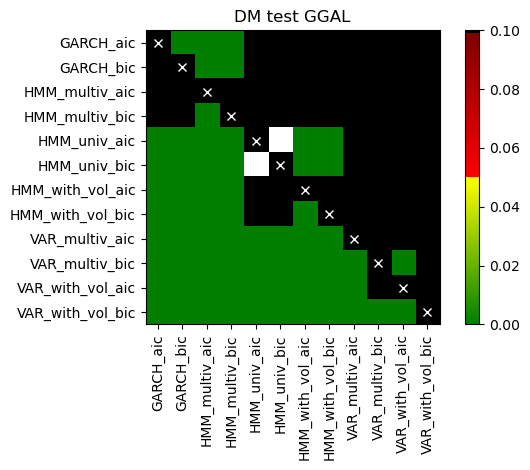

YPFD.BA


c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: divide by zero encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)


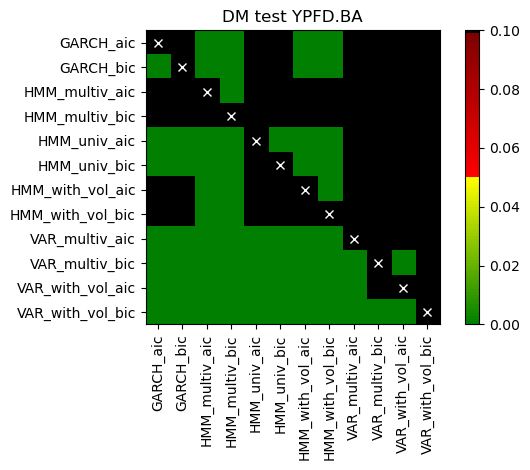

YPF


c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: invalid value encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)
c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: divide by zero encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)


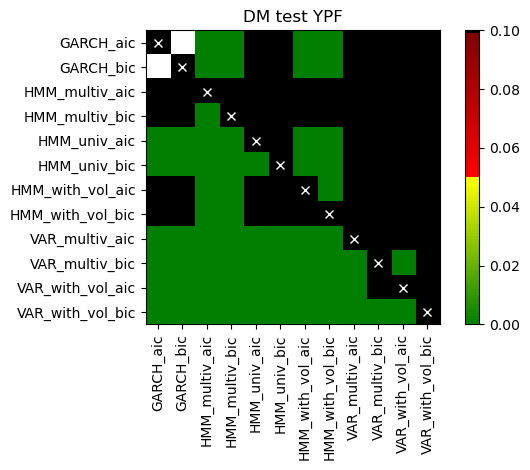

EDN.BA


c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: invalid value encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)
c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: divide by zero encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)


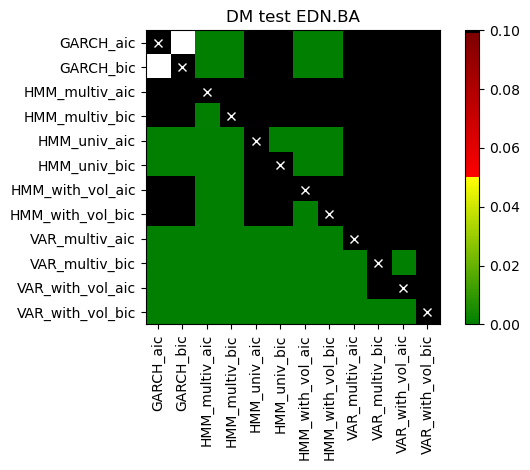

EDN


c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: divide by zero encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)


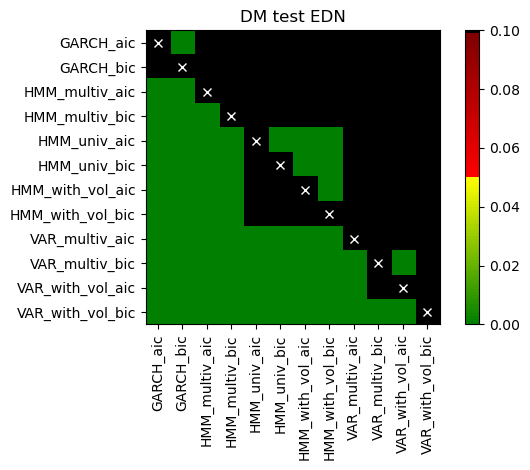

BMA.BA


c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: divide by zero encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)
c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: invalid value encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)


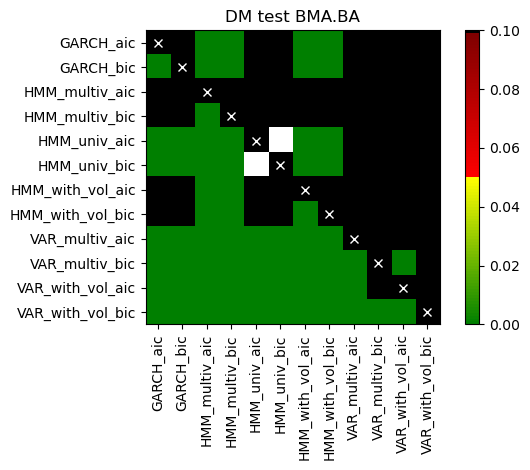

BMA


c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: divide by zero encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)


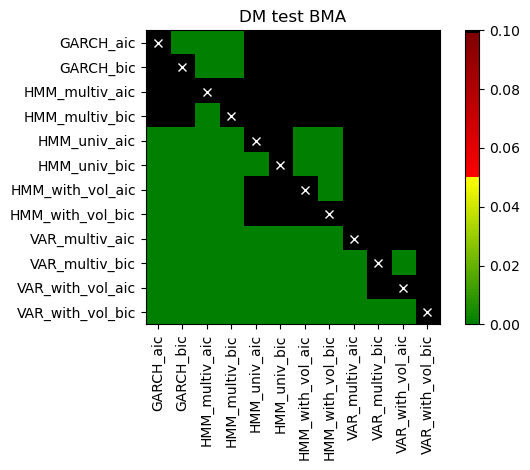

BBAR.BA


c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: divide by zero encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)
c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: invalid value encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)


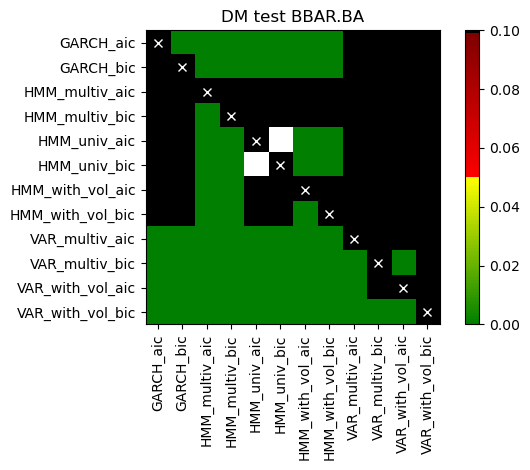

BBAR


c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: divide by zero encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)


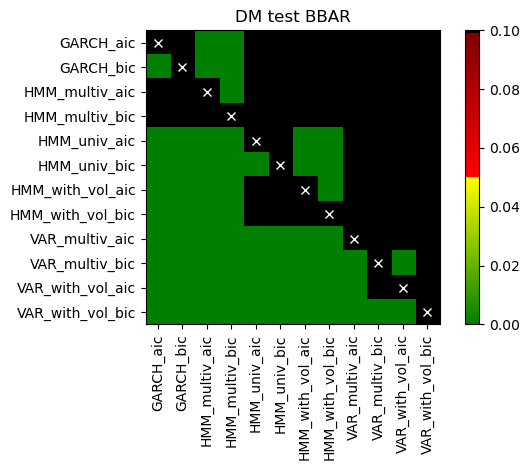

In [57]:
for stock in forecasts_by_stock.keys():
    print(stock)
    real_values=subset_of_columns(df_test, f"{stock}_log_rets")
    forecasts=delete_in_column_names(forecasts_by_stock[stock].fillna(0), f"_{stock}")   

    plot_multivariate_DM_test(real_price=real_values, 
                            forecasts=forecasts.fillna(0), 
                            title=f"DM test {stock}",
                            savefig=True,
                            path=dmroute)

In [58]:
best_models_by_stock={stock:None for stock in residuals_by_stock.keys()}

for stock, dataframe in residuals_by_stock.items():
    dataframe = delete_in_column_names(dataframe, f"_{stock}")
    metrics_df = pd.DataFrame(index=["mse", "meanabs", "medianabs"])

    for column in dataframe.columns:
        single_model=pd.DataFrame(dataframe[column])
        
        metrics_df.loc["mse", column] = (
            (single_model**2).mean().mean()
        )
        metrics_df.loc["meanabs", column] = (
            single_model.abs().mean().mean()
        )
        metrics_df.loc["medianabs", column] = (
            (single_model.abs()).median().median()
        )
    metrics_df = metrics_df * 100
    metrics_df = subset_of_columns(metrics_df, substring="", exclude="USD")
    
    best_dict={}
    for criterion in metrics_df.index:
        best_dict[criterion] = metrics_df.iloc[metrics_df.index==criterion].idxmin(axis="columns").values[0]
        
    best_models_by_stock[stock]= (metrics_df, best_dict)

In [59]:
print(params["tickerlist"][0])
best_models_by_stock[params["tickerlist"][0]][1]

^MERV


{'mse': 'VAR_multiv_aic',
 'meanabs': 'VAR_multiv_aic',
 'medianabs': 'VAR_multiv_aic'}

In [60]:
best_models_by_stock[params["tickerlist"][0]][0]

,GARCH_aic,GARCH_bic,HMM_multiv_aic,HMM_multiv_bic,HMM_univ_aic,HMM_univ_bic,HMM_with_vol_aic,HMM_with_vol_bic,VAR_multiv_aic,VAR_multiv_bic,VAR_with_vol_aic,VAR_with_vol_bic
mse,0.131800,0.133178,0.164581,0.159892,0.131662,0.131662,0.153822,0.156724,0.053305,0.127998,0.118424,0.148198
meanabs,2.790686,2.801741,3.084343,2.990571,2.886648,2.886648,2.950024,2.946597,1.721330,2.669034,2.576706,2.908731
medianabs,2.292540,2.281046,2.684663,2.459797,2.305330,2.305330,2.487083,2.451229,1.374278,2.057373,1.946020,2.250114


In [61]:
best_models_by_stock[params["tickerlist"][0]][0].rank(axis=1)

,GARCH_aic,GARCH_bic,HMM_multiv_aic,HMM_multiv_bic,HMM_univ_aic,HMM_univ_bic,HMM_with_vol_aic,HMM_with_vol_bic,VAR_multiv_aic,VAR_multiv_bic,VAR_with_vol_aic,VAR_with_vol_bic
mse,6.0,7.0,12.0,11.0,4.5,4.5,9.0,10.0,1.0,3.0,2.0,8.0
meanabs,4.0,5.0,12.0,11.0,6.5,6.5,10.0,9.0,1.0,3.0,2.0,8.0
medianabs,6.0,5.0,12.0,10.0,7.5,7.5,11.0,9.0,1.0,3.0,2.0,4.0


In [62]:
agg_df=(pd.DataFrame().reindex_like(best_models_by_stock[params["tickerlist"][0]][0]))

for asset in params["tickerlist"]:
    ranks = best_models_by_stock[asset][0].rank(axis=1)
    agg_df = agg_df.add(ranks, fill_value=0)
agg_df = agg_df/len(params["tickerlist"])
    
agg_df.rank(axis=1, method="average").astype(int)

,GARCH_aic,GARCH_bic,HMM_multiv_aic,HMM_multiv_bic,HMM_univ_aic,HMM_univ_bic,HMM_with_vol_aic,HMM_with_vol_bic,VAR_multiv_aic,VAR_multiv_bic,VAR_with_vol_aic,VAR_with_vol_bic
mse,8,10,11,12,3,4,6,7,1,5,2,9
meanabs,8,9,11,10,3,5,4,6,1,7,2,11
medianabs,10,8,11,6,5,7,4,2,1,11,2,8


In [63]:
agg_df.to_csv(os.path.join(resultsroute, f"""aggregate_results_df_{params["tablename"]}.csv"""))

In [64]:
criterion="mse"
print(f"Best overall performance by {criterion}")
agg_df.T.nsmallest(3, f"{criterion}").index.to_list()

Best overall performance by mse


['VAR_multiv_aic', 'VAR_with_vol_aic', 'HMM_univ_aic']